In [52]:
import torch
import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
import torch.optim as optim
import torch.utils.data as data
from torch.optim import lr_scheduler
from torch.autograd import Variable
import copy
import math
import matplotlib.pyplot as plt
import itertools
import librosa
from pathlib import Path

from sklearn.model_selection import train_test_split

import sys
import numpy as np

import pickle

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Running on device: {}'.format(device))
print(torch.cuda.get_device_name(0))

Running on device: cuda
NVIDIA GeForce RTX 2080 Ti


In [53]:
from transformers import AutoProcessor, AutoModelForCTC
model = AutoModelForCTC.from_pretrained("ydshieh/wav2vec2-large-xlsr-53-chinese-zh-cn-gpt")
model.to(device)

Wav2Vec2ForCTC(
  (wav2vec2): Wav2Vec2Model(
    (feature_extractor): Wav2Vec2FeatureExtractor(
      (conv_layers): ModuleList(
        (0): Wav2Vec2LayerNormConvLayer(
          (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,))
          (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        )
        (1): Wav2Vec2LayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,))
          (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        )
        (2): Wav2Vec2LayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,))
          (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        )
        (3): Wav2Vec2LayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,))
          (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        )
        (4): Wav2Vec2LayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(3,)

In [54]:
CHECKPOINT = '../models/chinese/data_aug/best_chi.pth'
DATASET_PATH = '../dataset/chinese_dataset/'
DEMO_PATH = '../dataset/demo_chi/'
NUM_CLASSES = 4
BATCHSIZE = 10
optimizer = optim.Adam(model.parameters())
scheduler = lr_scheduler.StepLR(optimizer, 10)
DROPOUT = 0.2
EMOTIONS = ['Angry', 'Happy', 'Neutral', 'Sad']

In [55]:
test_dataset = []
for i, emotion in enumerate(EMOTIONS):
    filepath = Path(DATASET_PATH + emotion + '/')
    for file in filepath.glob("*.wav"): 
        wav, rate = librosa.load(file, sr=16000, mono=True, res_type="kaiser_fast")
        tensor = torch.tensor(wav, device="cuda")
        test_dataset.append((tensor, i))
print(len(test_dataset))

160


In [56]:
demo_dataset = []
filepath = Path(DEMO_PATH + '/')
for file in filepath.glob("*.wav"): 
    print(file)
    wav, rate = librosa.load(file, sr=16000, mono=True, res_type="kaiser_fast")
    tensor = torch.tensor(wav, device="cuda")
    demo_dataset.append(tensor)
print(len(demo_dataset))

..\..\dataset\demo_chi\ang_00485_4_10.wav
..\..\dataset\demo_chi\hap_00485_2_3.wav
..\..\dataset\demo_chi\neu_00485_4_23.wav
..\..\dataset\demo_chi\sad_00485_3_3.wav
4


In [57]:
def sort_data(data_set):
    indices = sorted(range(len(data_set)),
                     key=lambda k: len(data_set[k][0]),
                     reverse=True)
    data_set = [data_set[i] for i in indices]
    return data_set, indices
sorted_test, test_indices = sort_data(test_dataset)

In [58]:
def pad_tensor(vec, pad, dim):
        pad_size = list(vec.shape)
        pad_size[dim] = pad - vec.size(dim)
        return torch.cat([vec, torch.zeros(*pad_size).cuda()], dim=dim)

def collate_fn(instances):
    
    max_len = max(map(lambda x: x[0].shape[0], instances))
    batch = []
    for (x,y) in instances:
        batch.append((pad_tensor(x, pad=max_len, dim=-1), y))
    
    f = list(map(lambda x: x[0], batch))
    l = list(map(lambda x: x[1], batch))
    features = torch.stack(f, dim=0)
    labels = torch.Tensor(l)
    return (features, labels)

dataloader = torch.utils.data.DataLoader(sorted_test, batch_size=BATCHSIZE,  num_workers=0, drop_last=True, collate_fn=collate_fn)

In [59]:
class TranferModel(nn.Module):

  def __init__(self, wav2vec, n_classes):
    super().__init__()
    self.wav2vec = wav2vec
    self.dropout = nn.Dropout(0.2)
    self.linear = nn.Linear(1024, n_classes)
    self.device = device
    self.to(self.device)

  def forward(self, input_values, attention_mask=None):
    x = self.wav2vec(input_values=input_values, output_hidden_states=True, attention_mask=attention_mask)
    x = x.hidden_states[0]
    # print(x.shape)
    x = x.mean(1)
    # print(x.shape)
    x = self.dropout(x)
    x = self.linear(x)
    return x

In [60]:
def load_trained_model(checkpoint_path):
    init_model = TranferModel(model, len(EMOTIONS))
    
    #load the weights
    try:
        checkpoint = torch.load(checkpoint_path)
        print("checkpoint loaded")
    except:
        checkpoint = None
        print("checkpoint not found")
    init_model.load_state_dict(checkpoint['model_state_dict'],strict=False)
    init_model.eval()
    return init_model

model = load_trained_model(CHECKPOINT)

checkpoint loaded


In [61]:
def test(model):
    criterion = nn.CrossEntropyLoss()
    confusion_matrix = torch.zeros(NUM_CLASSES, NUM_CLASSES)
    running_loss = 0.0
    running_corrects = 0

    with torch.no_grad():
        for (inputs, labels) in dataloader:
            inputs = inputs.to(device)
            labels = torch.tensor([i.long() for i in labels])
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            for t, p in zip(labels.view(-1), preds.view(-1)): 
                confusion_matrix[t.long(), p.long()] += 1

    test_loss = running_loss / 160
    test_acc = running_corrects.double() / 160
    cm = confusion_matrix.cpu().numpy().astype(int)

    # To get the per-class accuracy:
    class_acc = confusion_matrix.diag()/confusion_matrix.sum(1)
    print(class_acc.numpy().tolist())

    return test_loss, test_acc.cpu().item(), cm

In [62]:
test_loss, test_acc, confusion_matrix = test(model)
print("Test loss: ", test_loss)
print("Test accuracy: ", test_acc)

[0.875, 0.949999988079071, 0.625, 0.824999988079071]
Test loss:  0.567868422716856
Test accuracy:  0.8187500000000001


In [63]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=20)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=15)
    plt.yticks(tick_marks, classes, fontsize=15)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 fontsize=15, 
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[35  0  0  5]
 [ 0 38  2  0]
 [ 2 10 25  3]
 [ 3  0  4 33]]


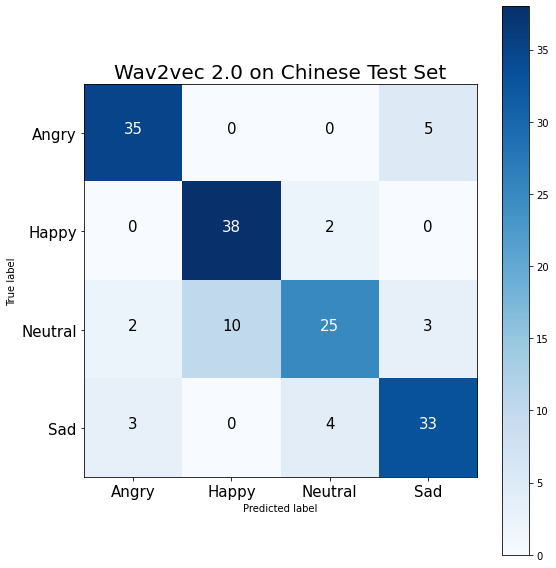

In [64]:
plt.figure(figsize=(8,8))
plot_confusion_matrix(confusion_matrix, EMOTIONS, title='Wav2vec 2.0 on Chinese Test Set')

In [65]:
precisions = [0.0, 0.0, 0.0, 0.0]
recalls = [0.0, 0.0, 0.0, 0.0]
for j in range(4):
    sum1 = 0
    sum2 = 0
    for i in range(4):
        sum1 += confusion_matrix[i][j]
        sum2 += confusion_matrix[j][i]
    precisions[j] = confusion_matrix[j][j] / sum1
    recalls[j] = confusion_matrix[j][j] / sum2

f1_score = []
for i in range(4):
    f1 = 2* (precisions[i]*recalls[i]) / (precisions[i]+recalls[i])
    f1_score.append(f1)
macro_f1 = (f1_score[0]+f1_score[1]+f1_score[2]+f1_score[3])/4
print("F1 Score: ", macro_f1)

F1 Score:  0.8144191326409637


In [66]:
for i in range(4):
    demo_input = demo_dataset[i].unsqueeze(0)
    demo_outputs = model(demo_input)
    _, demo_pred = torch.max(demo_outputs, 1)
    print("Prediction:", demo_pred.cpu().item())
    print("True label: ", i)

Prediction: 0
True label:  0
Prediction: 1
True label:  1
Prediction: 0
True label:  2
Prediction: 3
True label:  3
